In [1]:
!python --version

Python 3.10.0


In [2]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
from docs.examples.utils import clean_legend

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

key = jr.key(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rc('text', usetex=False)
plt.rcParams['font.family'] = 'DeJavu Serif'

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", message="findfont: Font family")

C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


### 1. Dataset

Creating a datasat, sampling from a normal distribution with mean sin(4x)+cos(2x) and a variance of 0.3**2 where I implies that the variance across different values/instances is constant and independent. 

In [3]:
n = 100
noise = 0.3

key, subkey = jr.split(key)

# Get 100 values between -3.0 and 3.0, uniformly distributed
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)

# Setup the function to define y for each x (signal + noise)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

# Turn it into a GPJax Dataset
D = gpx.Dataset(X=x, y=y)

# Test the obtained input- and output lables
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

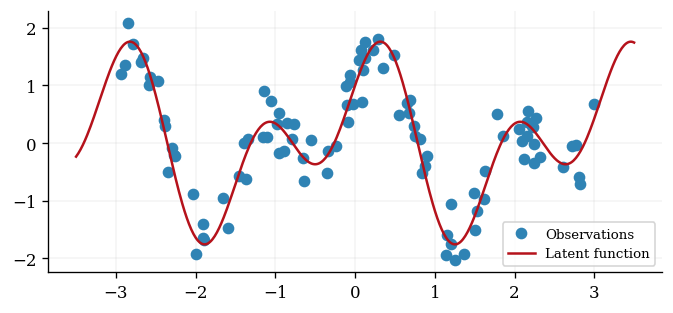

In [4]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")
plt.show()

### 2. Prior

Testing of the kernel function (defining the smoothness of the outputs) with a Radial Basis Function (RBF).

In [5]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

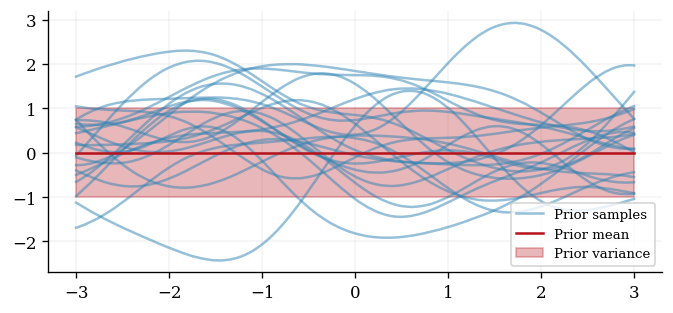

In [8]:
xtest = jnp.linspace(-3.0, 3.0, num=200).reshape(-1, 1)

# Prior distribution is the distribution without extra knowledge
prior_dist = prior.predict(xtest)

# Distillate the mean and variance to be able to sample functions
prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")
ax = clean_legend(ax)

### 3. Posterior

First construct the likelihood function: a gaussian with noise parameter alpha. 
Then define the posterior as prior * likelihood.

In [9]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

### 4. Parameters

Initialise with 0, then learn by optimising the Marginal Log-Likelihood (MLL).

In [12]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)


# static_tree = jax.tree_map(lambda x: not(x), posterior.trainables)
# optim = ox.chain(
#     ox.adam(learning_rate=0.01),
#     ox.masked(ox.set_to_zero(), static_tree)
#     )

print(gpx.cite(negative_mll))

# JIT-Compile (Just-In-Time) to reduce the expensive-to-compute function
negative_mll = jit(negative_mll)

@book{rasmussen2006gaussian,
authors = {Rasmussen, Carl Edward and Williams, Christopher K},
title = {Gaussian Processes for Machine Learning},
year = {2006},
publisher = {MIT press Cambridge, MA},
volume = {2},
}


In [13]:
# Use bfgs optimizer to define the parameter values
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D,
)

Optimization terminated successfully.
         Current function value: 55.103686
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17


### 5. Prediction

Use the posterior, likelihood and set of optimized hyperparameter values to get the predictive distribution.

In [17]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


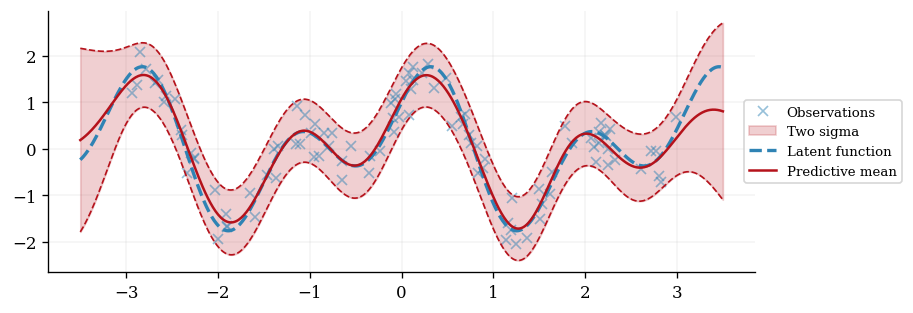

In [18]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
plt.show()